# Portfolio analysis
This notebook introduces the concept of portfolio-level analyses. In this notebook, the results of the asset-level analysis are translated into firm-level results which are subsequently translated into portfolio-level results.

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

import country_converter as coco

from prisk.utils import extract_firms, link_basins, convert_to_continous_damage, clean_owner_name
from prisk.portfolio import Portfolio
from prisk.plotting import plot_assets_and_basins #, compare_value_distributions, visualize_dependency_models, analyze_bootstrap_stability, compare_risk_models, generate_summary_table
from prisk.run_simulation import run_simulation

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [71]:
random_seed=0

insurer_capital = 2e9
flood_protection = 100
simulations = 100
return_period_columns = [5, 10, 25, 50, 100, 200, 500, 1000]

country = "India" # "India" or "Thailand"
copula = None # None or "gaussian" or "vine" or "t" or "complete_dependent"

All files for the analysis must be pre-downloaded, by running the script Data/download_app_files.py


In [72]:
if False:
    power = pd.read_excel("../Data/app/power.xlsx")


    def map_countries_to_iso2(df, column_name="Country"):
        """
        Map a DataFrame column of country names (English or French)
        to ISO2 codes using the country_converter library.
        """
        cc = coco.CountryConverter()
        df["country_iso2"] = df[column_name].apply(
            lambda x: cc.convert(names=x, to='ISO2')
        )
        return df

    power = map_countries_to_iso2(power)
    power.to_csv("../Data/app/power_iso2.csv", index=False)
else:
    power = pd.read_csv("../Data/app/power_iso2.csv")
    power = power.rename(columns={"2":2,	"5":5,	"10":10,	"25":25,	"50":50,	"100":100,	"200":200,	"500":500,	"1000":1000})

In [73]:
financial_data_medians = pd.read_csv("../Data/app/financial_medians.csv")
financial_data_power = financial_data_medians.loc[financial_data_medians["sector"] == "Power",:]

financial_data = pd.merge(financial_data_power, power, on=["country_iso2"])
financial_data = financial_data.loc[:,["Owner", "Plant / Project name", "debt_equity_ratio"]]
financial_data = financial_data.rename(columns={"debt_equity_ratio":"Leverage Ratio"})

median_ratio = financial_data["Leverage Ratio"].median()
financial_data["Leverage Ratio"].fillna(median_ratio, inplace=True)

leverage_ratios = {
        clean_owner_name(str(firm)): leverage
        for firm, leverage in zip(
            financial_data["Owner"], financial_data["Leverage Ratio"]
        )
    }

financial_data["Owner"] = financial_data["Owner"].str.split(";")
financial_data = financial_data.explode("Owner", ignore_index=True)

Load and process damage curves

In [74]:
damage_curves_file = "../Data/app/damage_curves.xlsx"
damage_curves = pd.read_excel(damage_curves_file)  # Load damage curves
continuous_curves = convert_to_continous_damage(
    damage_curves
)

The files containing the randomly generated samples can be generated using the notebooks found in the Exploratory analysis folder. Alternatively, they can be downloaded from the link in the package README.md file.

##### Extracting Agents
The P-RISK model is based on asset-level analyses that are subsequently translated into firm- and portfolio-level impacts. To extract the firms from the Global Energy Monitor database, we use a utility function. If this approach is applied on a different dataset, then the extract_firms function needs to be replaced. We assume flood protection levels (consistent with other literature).

We limit the analysis to a single country.

In [103]:
assets = power[power["Country"] == country].copy().reset_index(drop=True).drop(columns=[2])
assets.loc[:, "flood_protection"] = assets[flood_protection]
firms, assets_processed = extract_firms(
        assets,
        return_period_columns=return_period_columns,
        leverage_ratios=leverage_ratios,
        damage_curves=continuous_curves
        )
firms = [firm for firm in firms if firm.name != "Jharkhand State Electricity Board"]

##### Portfolio construction
The portfolio consists of the firms linked to the assets located in Thailand. We assume an equal weighted portfolio:

In [104]:
portfolio = Portfolio(f"{country} power assets")
nav = 0.2
for firm in firms:
    firm_exposure_usd = nav/(len(firms)*firm.npv)
    portfolio.add_position(firm, firm_exposure_usd)

# Conduct simulation
The prisk simulations are still performed at the asset-level but due to the set-up with python classes, the results can easily be analysed at the portfolio-level. In each notebook, we perform multiple versions of the prisk framework that differentiate in the dependency modelling framework that was used. The five frameworks are:
1. **Completely independent events**: each asset has independent flood events that occur.
2. **Basin-level dependence**: floods are simulated at the basin-level. Whenever a flood occurs in a basin, all assets located inside that basin are affected. The floods between basins are assumed to be independent.
3. **Complete dependence**: the dependency of floods between basins are modelled using three copula functions: (1) gaussian copula, (2) the t-copula, and (3) the vine copula.

At the beginning of each of the model cells, we set the random seed. This ensures that the results are (1) completely reproducible, (2) perfectly compareable across different notebook versions (robustness checks), and (3) perfectly comparable across different dependency modelling approaches.


## 1. Complete independence

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager


def analysis_fun(portfolio_values, num_bootstraps, m, quantile):

    bootstrapped_quantiles = []
    for _ in range(num_bootstraps):
        sample = np.random.choice(portfolio_values, size=int(len(portfolio_values)*m), replace=False)
        boot_q = np.quantile(sample, quantile)
        bootstrapped_quantiles.append(boot_q)
    
    boot_mean = np.mean(bootstrapped_quantiles)
    boot_lb = np.quantile(bootstrapped_quantiles, 0.025)  # 95% CI lower bound
    boot_up = np.quantile(bootstrapped_quantiles, 0.975)  # 95% CI upper bound
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(bootstrapped_quantiles, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(boot_mean, color='red', linestyle='--', label=f"Mean {quantile*100}% Quantile")
    plt.axvline(boot_lb, color='green', linestyle=':', label="95% CI Lower Bound")
    plt.axvline(boot_up, color='green', linestyle=':', label="95% CI Upper Bound")
    plt.xlabel(f"{int(quantile*100)}% Quantile of Portfolio Values", fontsize=14, fontfamily="Times New Roman")
    plt.ylabel("Frequency", fontsize=14, fontfamily="Times New Roman")
    plt.title(f"Bootstrap Analysis of Portfolio Values", fontsize=16, fontfamily="Times New Roman")
    plt.legend(fontsize=12, prop=font_manager.FontProperties(family="Times New Roman"))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    plt.close()
    

### Kernel insurance

In [106]:
# Scenario 1: Complete Independence without Insurance
sim_result = run_simulation(
    random_numbers=None,  # No copula applied
    assets_df=assets_processed,        # Independent assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=10,
    seed=random_seed,
    insured=False,                # No insurance
    insurer_capital=insurer_capital,
    dropout_time=None,            # No dropout
    calculate_pds=True,          # No PD calculations
    sigma=0.6
)

# Extract portfolio values
portfolio_values = sim_result["portfolio_values"]


Simulating No Copula:   0%|          | 0/100 [00:00<?, ?it/s]

Simulating No Copula: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


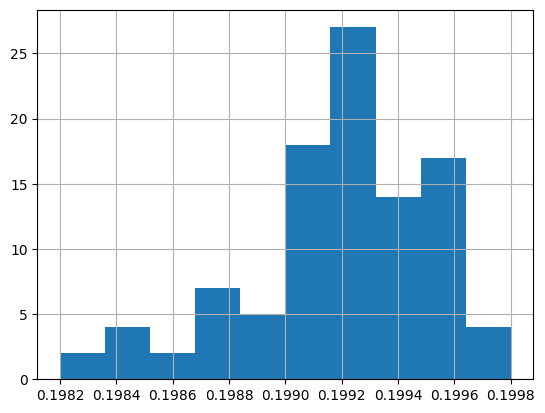

In [107]:
pd.Series(portfolio_values).hist();

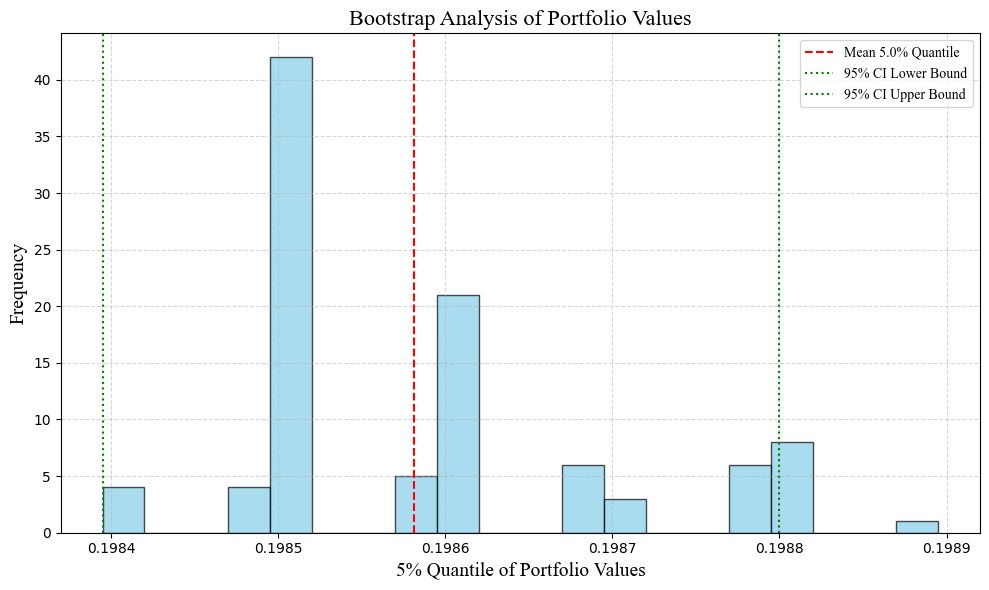

In [108]:
analysis_fun(
    portfolio_values, 
    num_bootstraps=100,
    quantile=0.05,
    m=0.4)

In [115]:
empirical_pds = sim_result["empirical_pds"].mean(axis=0)
empirical_pds = empirical_pds.reset_index().rename(columns={"index":"company_name", 0:"empirical_pd"})
merton_pds = sim_result["merton_pds"].mean(axis=0)
merton_pds = merton_pds.reset_index().rename(columns={"index":"company_name", 0:"merton_pd"})

pd.merge(empirical_pds, merton_pds, on=["company_name"])

,company_name,empirical_pd,merton_pd
0,Acb (India),0.000308,1.304676e-06
1,Ars Metals,0.000157,6.232819e-07
2,Aarti Steels,0.005781,3.302884e-05
3,Abhijeet Group,0.000013,4.312151e-08
4,Adani Power,0.000076,2.549711e-07
...,...,...,...
226,Uttar Pradesh Rajya Vidyut Utpadan Nigam,0.000008,2.518740e-08
227,Vandana Vidhyut,0.000009,2.748688e-08
228,Vedanta Resources,0.000539,3.042822e-06
229,Warana Sugar Co-Operative,0.000637,4.100666e-06


### Insured CapDam

Simulation with Insurance defined at the asset level

In [11]:
# Scenario 2: Complete Independence with Insurance
sim_result = run_simulation(
    random_numbers=None,    # No copula applied
    assets_df=assets_processed,          # Independent assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=True,            # Insurance included
    insurer_capital=insurer_capital,
    dropout_time=None,        # No dropout
    calculate_pds=False,      # No PD calculations
    sigma=0.2                  # Irrelevant since calculate_pds=False
)

# Extract portfolio values
portfolio_values = sim_result["portfolio_values"]


Simulating No Copula:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating No Copula: 100%|██████████| 10/10 [00:01<00:00,  9.35it/s]


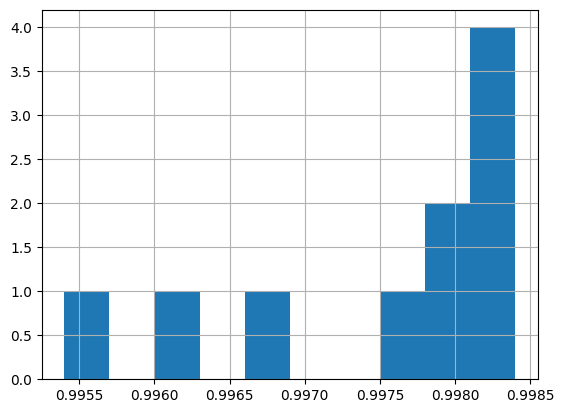

In [12]:
pd.Series(portfolio_values).hist();

### Insurance dropout

Simulation with InsuranceDropoutEvent

In [13]:
# Additional param
dropout_time = 3

In [14]:

sim_result = run_simulation(
    random_numbers=None,    # No copula applied
    assets_df=assets_processed,          # Independent assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=True,            # Insurance included
    insurer_capital=insurer_capital,
    dropout_time=dropout_time,  # Insurance dropout after specified time
    calculate_pds=False,        # No PD calculations
)

portfolio_values = sim_result["portfolio_values"]


Simulating No Copula:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating No Copula: 100%|██████████| 10/10 [00:00<00:00, 11.16it/s]


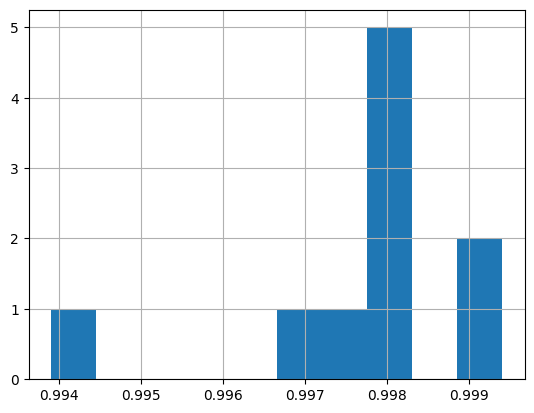

In [15]:
pd.Series(portfolio_values).hist();

### Merton Defaults and Insurance without dropout

In [16]:
# additional param
sigma=0.2

In [17]:
# Scenario 4: Complete Independence with Merton PD Calculations
sim_result = run_simulation(
    random_numbers=None,    # No copula applied
    assets_df=assets_processed,          # Independent assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=True,            # Insurance included
    insurer_capital=insurer_capital,
    dropout_time=None,        # No dropout
    calculate_pds=True,        # Enable PD calculations
    sigma=sigma                    # Volatility parameter for Merton model
)

# Extract PDs
empirical_independence = sim_result["empirical_pds"].values.tolist()
merton_independence = sim_result["merton_pds"].values.tolist()

# Extract portfolio values if needed
portfolio_values_4 = sim_result["portfolio_values"]


Simulating No Copula: 100%|██████████| 10/10 [00:01<00:00,  7.56it/s]


## 2. Basin-Level dependence
First, we start up by linking the asset locations to a specific basin. The geopandas package is used.

In [9]:
assets_with_basins, basins_processed = link_basins(assets_processed, basins=basins, country_basins=country_basins);

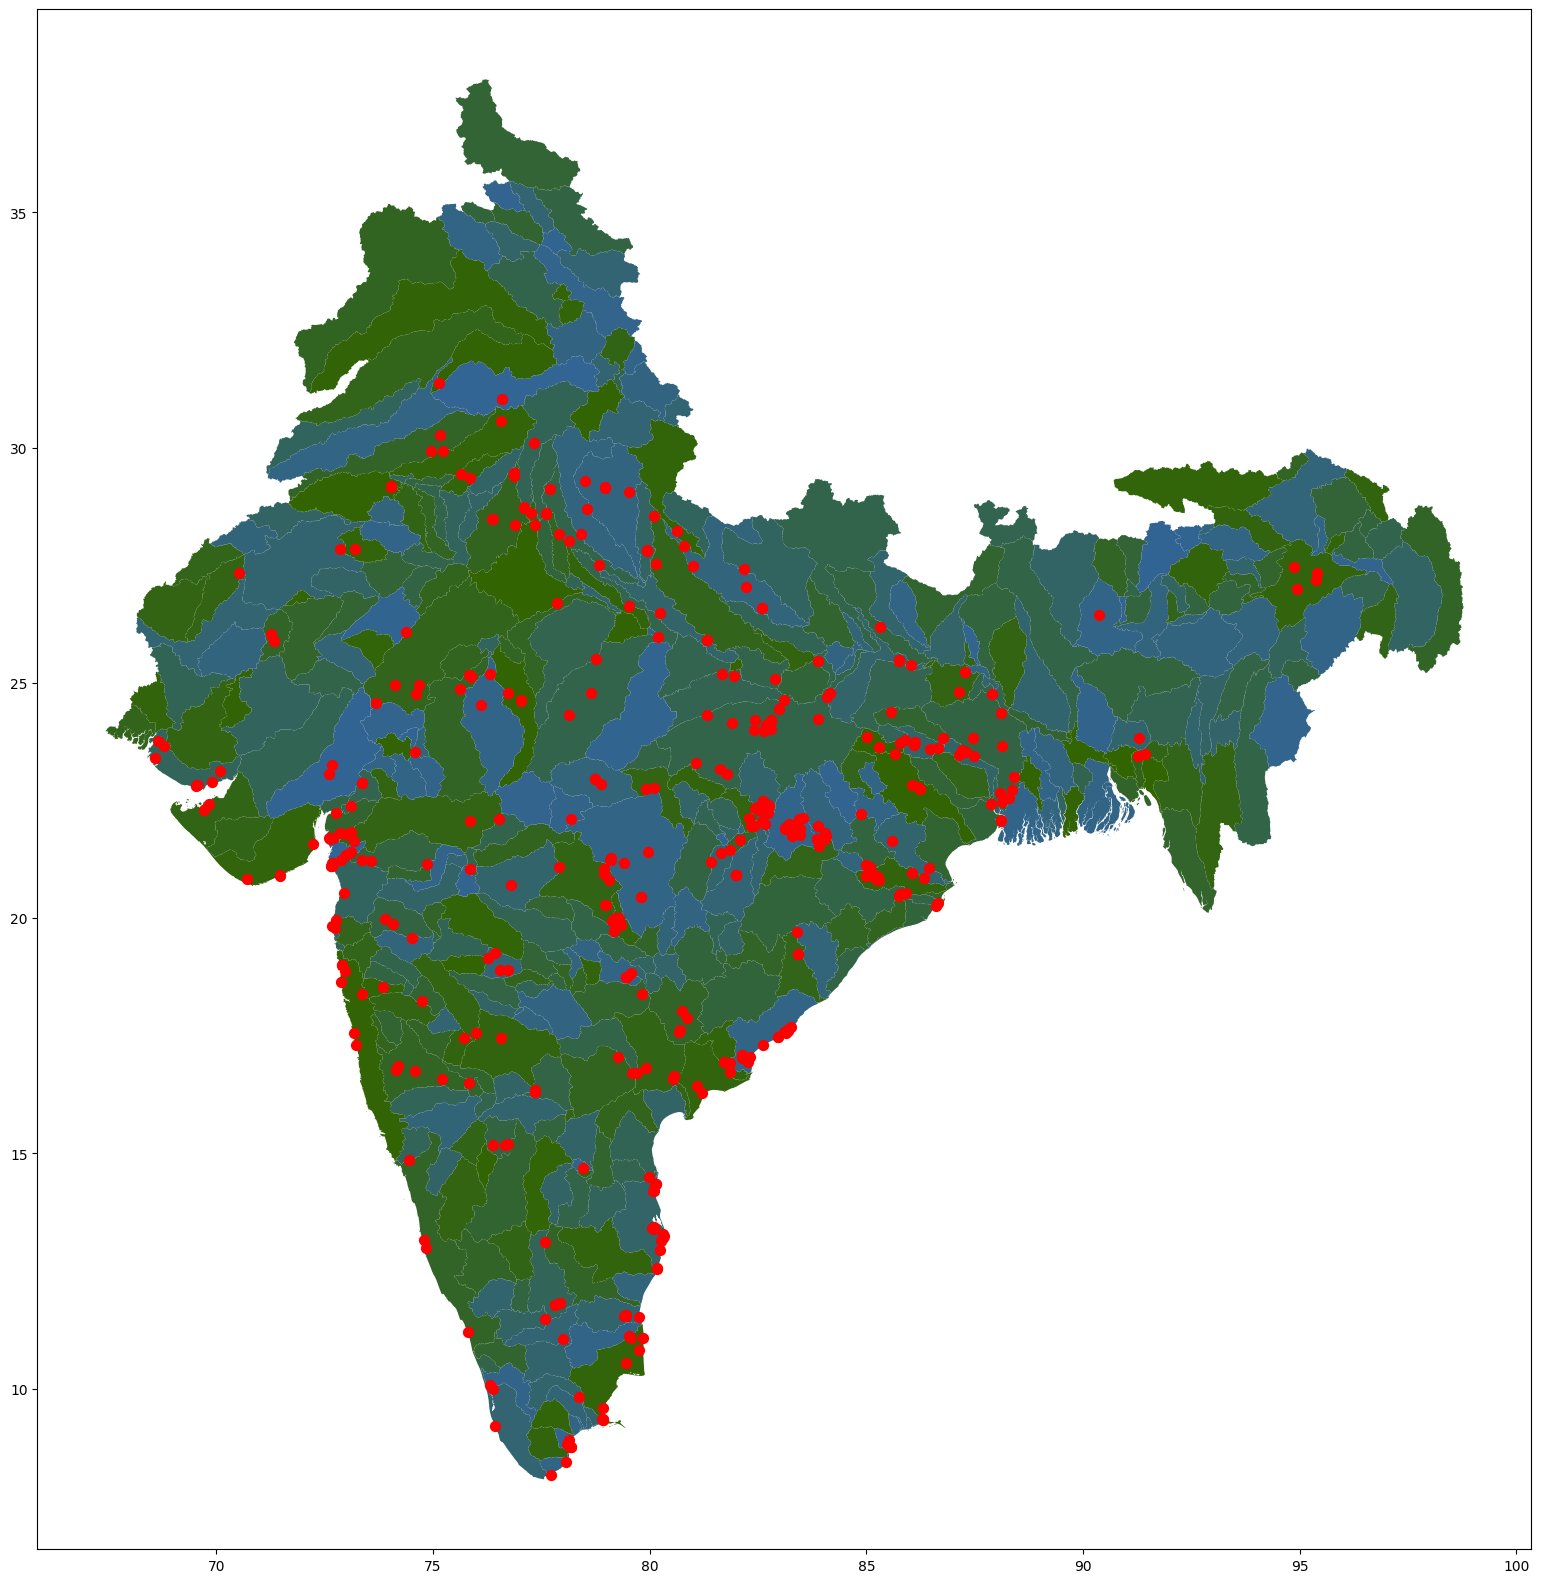

In [10]:
plot_assets_and_basins(assets_with_basins=assets_with_basins, basins_processed=basins_processed)

Once the basins are obtained, we simulate events at the basin level and incorporate it into the simulation:

### Kernel insurance

In [ ]:
# Scenario 8: Basin-Level Dependence with Merton PD Calculations
# Assuming 'complete_dependent_random_numbers' corresponds to the desired copula type for basin-level dependence
sim_result = run_simulation(
    random_numbers=random_numbers,  # Copula applied (e.g., 'complete_dependent')
    assets_df=assets_with_basins,                            # Basin-linked assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=True,                                        # Insurance included
    insurer_capital=insurer_capital,
    dropout_time=None,                                    # No dropout
    calculate_pds=True,                                    # Enable PD calculations
    sigma=0.2,                                              # Volatility parameter for Merton model
    return_period_columns=return_period_columns # used only if random_numbers is not None i.e. copula applied
)

# Extract PDs
empirical_independent_basins = sim_result["empirical_pds"].values.tolist()
merton_independent_basins = sim_result["merton_pds"].values.tolist()

# Extract portfolio values if needed
portfolio_values = sim_result["portfolio_values"]


Simulating With Copula:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating With Copula: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


In [20]:
# Scenario 5: Basin-Level Dependence without Insurance
# Assuming 'vine_random_numbers' corresponds to the desired copula type for basin-level dependence
sim_result = run_simulation(
    random_numbers=random_numbers,  # Copula applied (e.g., 'vine')
    assets_df=assets_with_basins,            # Basin-linked assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=False,                        # No insurance
    insurer_capital=insurer_capital,
    dropout_time=None,                    # No dropout
    calculate_pds=False,                  # No PD calculations
    return_period_columns=return_period_columns # used only if random_numbers is not None i.e. copula applied
)

# Extract portfolio values
portfolio_values = sim_result["portfolio_values"]


Simulating With Copula:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating With Copula: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


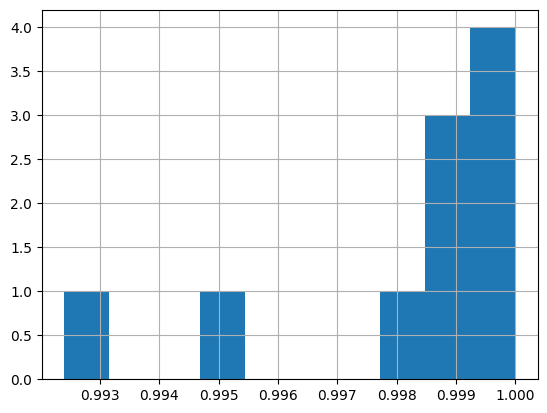

In [21]:
pd.Series(portfolio_values).hist();

### Insured CapDam

Simulation with simple Insurance

In [23]:
# Scenario 6: Basin-Level Dependence with Insurance
# Assuming 'gaussian_random_numbers' corresponds to the desired copula type for basin-level dependence
sim_result = run_simulation(
    random_numbers=random_numbers,  # Copula applied (e.g., 'gaussian')
    assets_df=assets_with_basins,                # Basin-linked assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=True,                              # Insurance included
    insurer_capital=insurer_capital,
    dropout_time=None,                          # No dropout
    calculate_pds=False,                        # No PD calculations
    return_period_columns=return_period_columns # used only if random_numbers is not None i.e. copula applied

)

# Extract portfolio values
portfolio_values = sim_result["portfolio_values"]


Simulating With Copula: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


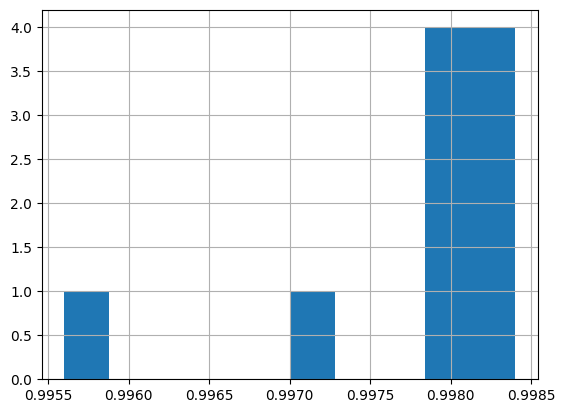

In [24]:
pd.Series(portfolio_values).hist();

### Insurance dropout

Simulation with InsuranceDropoutEvent

In [26]:
# Scenario 7: Basin-Level Dependence with Insurance Dropout
dropout_time = 3  # Define dropout time as per your setup

# Assuming 't_random_numbers' corresponds to the desired copula type for basin-level dependence
sim_result = run_simulation(
    random_numbers=random_numbers,           # Copula applied (e.g., 't')
    assets_df=assets_with_basins,                  # Basin-linked assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=True,                                # Insurance included
    insurer_capital=insurer_capital,
    dropout_time=dropout_time,                    # Insurance dropout after specified time
    calculate_pds=False,                          # No PD calculations
    return_period_columns=return_period_columns # used only if random_numbers is not None i.e. copula applied
)

# Extract portfolio values
portfolio_values = sim_result["portfolio_values"]


Simulating With Copula:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating With Copula: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


### Merton Defaults and Insurance without dropout

In [27]:
# additional param
sigma=0.2

In [29]:
# Scenario 8: Basin-Level Dependence with Merton PD Calculations
# Assuming 'complete_dependent_random_numbers' corresponds to the desired copula type for basin-level dependence
sim_result = run_simulation(
    random_numbers=random_numbers,  # Copula applied (e.g., 'complete_dependent')
    assets_df=assets_with_basins,                            # Basin-linked assets
    firms=firms,
    portfolio=portfolio,
    simulations=simulations,
    time_horizon=25,
    seed=random_seed,
    insured=True,                                        # Insurance included
    insurer_capital=insurer_capital,
    dropout_time=None,                                    # No dropout
    calculate_pds=True,                                    # Enable PD calculations
    sigma=0.2,                                              # Volatility parameter for Merton model
    return_period_columns=return_period_columns # used only if random_numbers is not None i.e. copula applied
)

# Extract PDs
empirical_independent_basins = sim_result["empirical_pds"].values.tolist()
merton_independent_basins = sim_result["merton_pds"].values.tolist()

# Extract portfolio values if needed
portfolio_values = sim_result["portfolio_values"]


Simulating With Copula:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating With Copula: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


# Summary of results

## Generate all results

In [14]:
# Define Copulas and Corresponding Random Numbers
copulas_to_simulate = [None, 'gaussian', 't', 'vine', 'complete_dependent']  # None represents 'uniform'

# Initialize Results Dictionary
simulation_results = {}

# Define Dropout Time (adjust as needed)
dropout_time = 3  # Example: Insurance drops out after 3 years

# Iterate Through Each Copula Type
for copula in copulas_to_simulate:
    # Determine Copula Label
    copula_label = copula if copula is not None else "uniform"
    
    # Select Appropriate Random Numbers and Assets
    if copula is None:
        random_numbers = None  # No copula applied
        current_assets = assets_processed  # Independent assets
    else:
        # Map copula to corresponding random_numbers DataFrame
        if copula == 'gaussian':
            random_numbers = gaussian_random_numbers
        elif copula == 't':
            random_numbers = t_random_numbers
        elif copula == 'vine':
            random_numbers = vine_random_numbers
        elif copula == 'complete_dependent':
            random_numbers = complete_dependent_random_numbers
        else:
            raise ValueError(f"Unsupported copula type: {copula}")
        
        current_assets = assets_with_basins  # Basin-linked assets
    
    # Define Scenario Labels
    scenario_labels = [
        f"{copula_label}_No_Insurance",
        f"{copula_label}_With_Insurance",
        f"{copula_label}_With_Insurance_Dropout",
        f"{copula_label}_With_PD"
    ]
    
    # Run Simulations for Each Scenario
    # 1. No Insurance
    result_no_insurance = run_simulation(
        random_numbers=random_numbers,
        assets_df=current_assets,
        firms=firms,
        portfolio=portfolio,
        simulations=simulations,
        time_horizon=25,
        seed=random_seed,
        insured=False,
        insurer_capital=insurer_capital,
        dropout_time=None,
        calculate_pds=False,
        sigma=0.2,
        return_period_columns=return_period_columns
    )
    simulation_results[scenario_labels[0]] = result_no_insurance
    
    # 2. With Insurance
    result_with_insurance = run_simulation(
        random_numbers=random_numbers,
        assets_df=current_assets,
        firms=firms,
        portfolio=portfolio,
        simulations=simulations,
        time_horizon=25,
        seed=random_seed,
        insured=True,
        insurer_capital=insurer_capital,
        dropout_time=None,
        calculate_pds=False,
        sigma=0.2,
        return_period_columns=return_period_columns
    )
    simulation_results[scenario_labels[1]] = result_with_insurance
    
    # 3. With Insurance Dropout
    result_with_dropout = run_simulation(
        random_numbers=random_numbers,
        assets_df=current_assets,
        firms=firms,
        portfolio=portfolio,
        simulations=simulations,
        time_horizon=25,
        seed=random_seed,
        insured=True,
        insurer_capital=insurer_capital,
        dropout_time=dropout_time,
        calculate_pds=False,
        sigma=0.2,
        return_period_columns=return_period_columns
    )
    simulation_results[scenario_labels[2]] = result_with_dropout
    
    # 4. With Merton PD Calculations
    result_with_pd = run_simulation(
        random_numbers=random_numbers,
        assets_df=current_assets,
        firms=firms,
        portfolio=portfolio,
        simulations=simulations,
        time_horizon=25,
        seed=random_seed,
        insured=True,
        insurer_capital=insurer_capital,
        dropout_time=None,
        calculate_pds=True,
        sigma=0.2,
        return_period_columns=return_period_columns
    )
    simulation_results[scenario_labels[3]] = result_with_pd


Simulating With Copula: 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


## Do plots

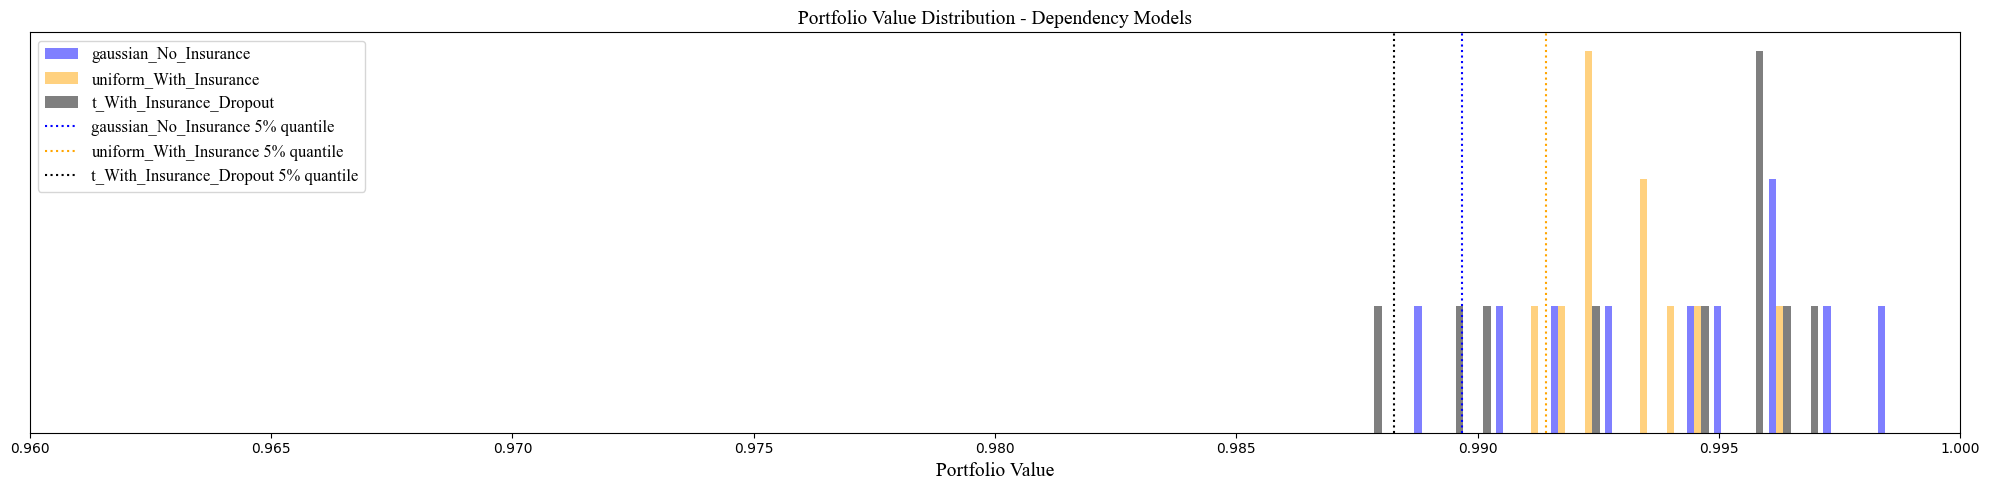

In [17]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

def plot_portfolio_value_histograms(simulation_results, labels, colors, quantiles, xlim, xlabel, title, hide_yaxis, font_size=14, font_family="Times New Roman", save_path="portfolio_value_histograms.png"):
    """
    Plots overlapping histograms of portfolio values for different scenarios.

    Parameters:
    - simulation_results (dict): Dictionary containing portfolio values for each scenario.
    - labels (list): List of labels for each histogram.
    - colors (list): List of colors for each histogram.
    - quantiles (dict): Dictionary of quantile values for each scenario.
    - xlim (tuple): Tuple specifying the x-axis limits.
    - xlabel (str): Label for the x-axis.
    - title (str): Plot title.
    - hide_yaxis (bool): Whether to hide the y-axis.
    - font_size (int): Font size for labels and title.
    - font_family (str): Font family for labels and title.
    - save_path (str): File path to save the plot.
    """
    plt.figure(figsize=(20, 5))
    data = [simulation_results[label]["portfolio_values"] for label in labels]
    
    plt.hist(data, bins=20, color=colors, label=labels, alpha=0.5, density=True)
    
    # Plot quantile lines
    for label in labels:
        plt.axvline(quantiles[label], color=colors[labels.index(label)], linestyle=":", label=f"{label} 5% quantile")
    
    # Customize plot
    plt.xlabel(xlabel, fontsize=font_size, fontfamily=font_family)
    plt.xlim(xlim)
    plt.title(title, fontsize=font_size, fontfamily=font_family)
    plt.legend(prop=font_manager.FontProperties(family=font_family, size=12))
    
    if hide_yaxis:
        plt.gca().axes.get_yaxis().set_visible(False)
    
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path, transparent=True)
    plt.close()


# Define scenarios to plot histograms
histogram_labels = [
    "gaussian_No_Insurance",
    "uniform_With_Insurance",
    "t_With_Insurance_Dropout"
]  # Adjust based on your specific scenarios

# Ensure these labels exist in simulation_results
histogram_labels = [label for label in histogram_labels if label in simulation_results]

# Define colors for each histogram
histogram_colors = ["blue", "orange", "black"]

# Define quantiles for each scenario
quantiles_hist = {
    label: simulation_results[label]["portfolio_values"].quantile(0.05)
    for label in histogram_labels
}

# Generate the histogram plot
plot_portfolio_value_histograms(
    simulation_results=simulation_results,
    labels=histogram_labels,
    colors=histogram_colors,
    quantiles=quantiles_hist,
    xlim=(0.96, 1),
    xlabel="Portfolio Value",
    title="Portfolio Value Distribution - Dependency Models",
    hide_yaxis=True,
    font_size=14,
    font_family="Times New Roman",
    save_path="portfolio_value_distribution_histograms.png"
)


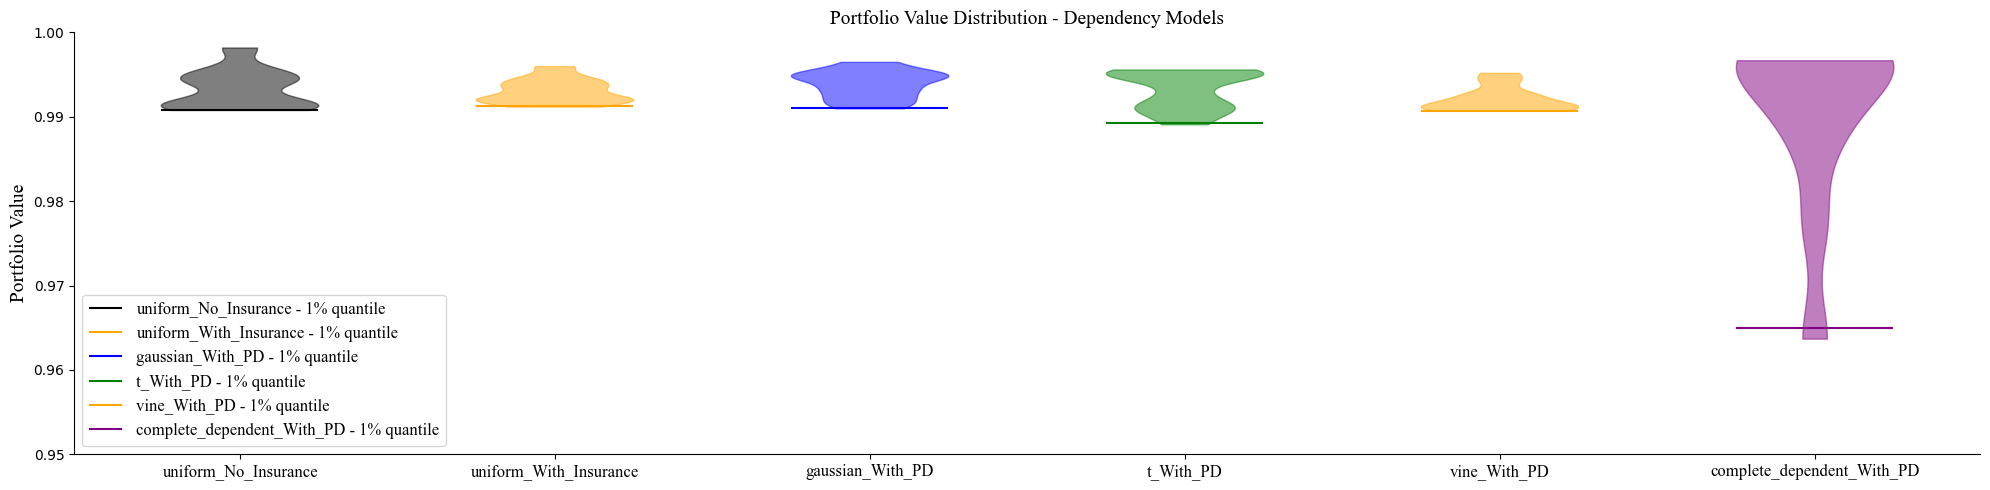

In [19]:
def plot_portfolio_value_violin(simulation_results, labels, colors, quantiles_dict, ylabel, title, ylim, font_size=14, font_family="Times New Roman", save_path="portfolio_value_violin.png"):
    """
    Plots violin plots of portfolio values for different scenarios.

    Parameters:
    - simulation_results (dict): Dictionary containing portfolio values for each scenario.
    - labels (list): List of labels for each violin plot.
    - colors (list): List of colors for each violin plot.
    - quantiles_dict (dict): Dictionary containing tuples of (Q1, LB, UB) for each scenario.
    - ylabel (str): Label for the y-axis.
    - title (str): Plot title.
    - ylim (tuple): Tuple specifying the y-axis limits.
    - font_size (int): Font size for labels and title.
    - font_family (str): Font family for labels and title.
    - save_path (str): File path to save the plot.
    """
    plt.figure(figsize=(20, 5))
    data = [simulation_results[label]["portfolio_values"] for label in labels]
    
    vp = plt.violinplot(data, showmeans=False, showextrema=False, bw_method=0.4)
    
    # Set colors
    for i, pc in enumerate(vp["bodies"]):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor(colors[i])
        pc.set_alpha(0.5)
    
    # Plot quantile lines
    for i, label in enumerate(labels):
        Q1 = quantiles_dict[label]["Q1"]
        plt.hlines(Q1, i + 0.75, i + 1.25, color=colors[i], label=f"{label} - 1% quantile")
        # Optional: Add lower and upper bounds if needed
    
    # Customize plot
    plt.ylabel(ylabel, fontsize=font_size, fontfamily=font_family)
    plt.title(title, fontsize=font_size, fontfamily=font_family)
    plt.ylim(ylim)
    
    # Customize x-axis labels
    plt.xticks(range(1, len(labels) + 1), labels, fontsize=12, fontfamily=font_family)
    
    # Add legend
    font_man = font_manager.FontProperties(family=font_family, size=12)
    plt.legend(prop=font_man, loc="lower left")
    
    # Hide top and right spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path, transparent=True)
    plt.close()



# Define scenarios to plot violin plots
violin_labels = [
    "uniform_No_Insurance",
    "uniform_With_Insurance",
    "gaussian_With_PD",
    "t_With_PD",
    "vine_With_PD",
    "complete_dependent_With_PD"
]  # Adjust based on your specific scenarios

# Ensure these labels exist in simulation_results
violin_labels = [label for label in violin_labels if label in simulation_results]

# Define colors for each violin plot
violin_colors = ["black", "orange", "blue", "green", "orange", "purple"]

# Define quantiles for each scenario
quantiles_violin = {}
for label in violin_labels:
    quantiles_violin[label] = {
        "Q1": simulation_results[label]["portfolio_values"].quantile(0.01)
    }

# Generate the violin plot
plot_portfolio_value_violin(
    simulation_results=simulation_results,
    labels=violin_labels,
    colors=violin_colors,
    quantiles_dict=quantiles_violin,
    ylabel="Portfolio Value",
    title="Portfolio Value Distribution - Dependency Models",
    ylim=(0.95, 1),
    font_size=14,
    font_family="Times New Roman",
    save_path="portfolio_value_distribution_violin.png"
)


In [22]:
def generate_pd_summary(simulation_results, scale=1000):
    """
    Generates summary tables for Empirical and Merton PDs.

    Parameters:
    - simulation_results (dict): Dictionary containing simulation results with PDs.
    - scale (int): Scaling factor to adjust PD values (e.g., 1000).

    Returns:
    - empirical_summary (pd.DataFrame): Summary table for Empirical PDs.
    - merton_summary (pd.DataFrame): Summary table for Merton PDs.
    """
    empirical_data = {}
    merton_data = {}
    
    for label, result in simulation_results.items():
        if "empirical_pds" in result and "merton_pds" in result:
            empirical_summary = result["empirical_pds"].mean().to_frame(name="Average PD") * scale
            merton_summary = result["merton_pds"].mean().to_frame(name="Average PD") * scale
            empirical_data[label] = empirical_summary["Average PD"]
            merton_data[label] = merton_summary["Average PD"]
    
    empirical_summary = pd.DataFrame(empirical_data).T
    merton_summary = pd.DataFrame(merton_data).T
    
    return empirical_summary, merton_summary

# Generate summary tables for Empirical and Merton PDs
empirical_summary, merton_summary = generate_pd_summary(simulation_results, scale=1000)

# Display the summary tables
print("Empirical PDs Summary:")
print(empirical_summary)

print("\nMerton PDs Summary:")
print(merton_summary)

# Optionally, export to LaTeX for reporting
latex_empirical = empirical_summary.to_latex()
latex_merton = merton_summary.to_latex()

print("\nLaTeX Table for Empirical PDs:")
print(latex_empirical)

print("\nLaTeX Table for Merton PDs:")
print(latex_merton)


Empirical PDs Summary:
                            Asia Commercial Bank  Ares Strategic Mining Inc  \
uniform_With_PD                         3.245716                   1.864571   
gaussian_With_PD                        2.626141                   1.783309   
t_With_PD                               2.419805                   2.033723   
vine_With_PD                            1.753175                   2.304996   
complete_dependent_With_PD              3.261967                   2.611373   

                            Aarti Industries  Abhijeet Group  Adani Power Ltd  \
uniform_With_PD                    38.938436        0.326577         3.050569   
gaussian_With_PD                   37.017585        0.331952         2.334486   
t_With_PD                          42.456670        0.322529         2.798796   
vine_With_PD                       44.232066        0.347463         1.829536   
complete_dependent_With_PD         38.278071        0.302558         4.191996   

               

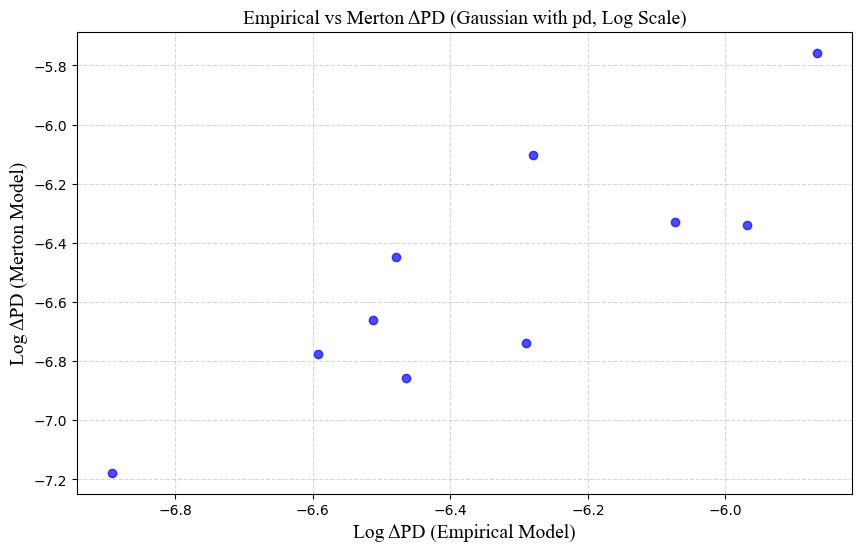

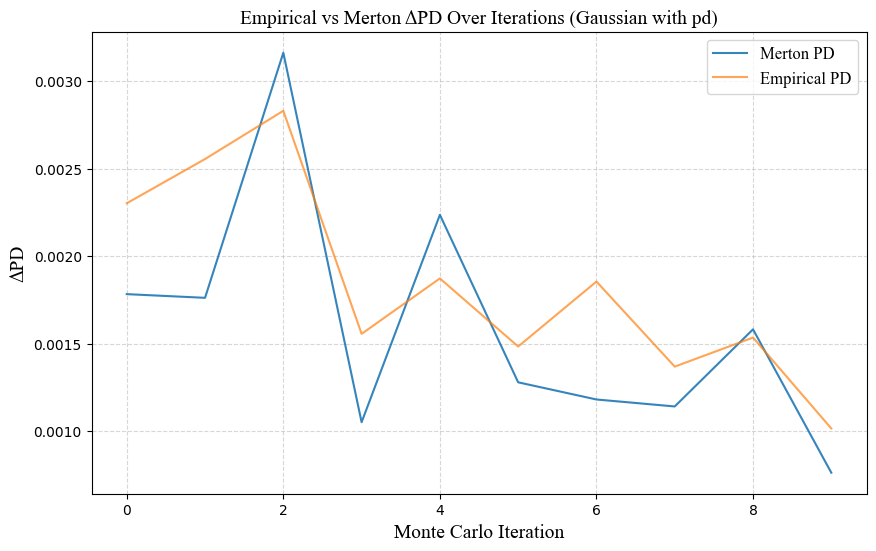

In [26]:
import numpy as np

def plot_pd_comparison(simulation_results, scenario_label, title_scatter, xlabel_scatter, ylabel_scatter, title_line, xlabel_line, ylabel_line, font_size=14, font_family="Times New Roman", save_scatter="pd_comparison_scatter.png", save_line="pd_comparison_line.png"):
    """
    Plots scatter and line plots comparing Empirical and Merton PDs.

    Parameters:
    - simulation_results (dict): Dictionary containing simulation results with PDs.
    - scenario_label (str): Specific scenario label to compare.
    - title_scatter (str): Title for the scatter plot.
    - xlabel_scatter (str): X-axis label for the scatter plot.
    - ylabel_scatter (str): Y-axis label for the scatter plot.
    - title_line (str): Title for the line plot.
    - xlabel_line (str): X-axis label for the line plot.
    - ylabel_line (str): Y-axis label for the line plot.
    - font_size (int): Font size for labels and title.
    - font_family (str): Font family for labels and title.
    - save_scatter (str): File path to save the scatter plot.
    - save_line (str): File path to save the line plot.
    """
    if scenario_label in simulation_results:
        result = simulation_results[scenario_label]
        if "empirical_pds" in result and "merton_pds" in result:
            empirical_pds = result["empirical_pds"].mean(axis=1)
            merton_pds = result["merton_pds"].mean(axis=1)
            
            # Scatter Plot
            plt.figure(figsize=(10, 6))
            plt.scatter(np.log(empirical_pds), np.log(merton_pds), alpha=0.7, color='blue')
            plt.xlabel(xlabel_scatter, fontsize=font_size, fontfamily=font_family)
            plt.ylabel(ylabel_scatter, fontsize=font_size, fontfamily=font_family)
            plt.title(title_scatter, fontsize=font_size, fontfamily=font_family)
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.savefig(save_scatter, transparent=True)
            plt.show()
            plt.close()
            
            # Line Plot
            plt.figure(figsize=(10, 6))
            plt.plot(merton_pds.values, label="Merton PD", alpha=0.9)
            plt.plot(empirical_pds.values, label="Empirical PD", alpha=0.7)
            plt.xlabel(xlabel_line, fontsize=font_size, fontfamily=font_family)
            plt.ylabel(ylabel_line, fontsize=font_size, fontfamily=font_family)
            plt.title(title_line, fontsize=font_size, fontfamily=font_family)
            plt.legend(prop=font_manager.FontProperties(family=font_family, size=12))
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.savefig(save_line, transparent=True)
            plt.show()
            plt.close()
        else:
            print(f"PD data not available for scenario: {scenario_label}")
    else:
        print(f"Scenario '{scenario_label}' not found in simulation results.")


# Define the specific scenario to compare PDs
scenario_label = 'gaussian_With_PD'  # Example: 't_With_PD', 'vine_With_PD', etc.

# Define plot titles and labels
title_scatter = f"Empirical vs Merton ΔPD ({scenario_label.replace('_', ' ').capitalize()}, Log Scale)"
xlabel_scatter = "Log ΔPD (Empirical Model)"
ylabel_scatter = "Log ΔPD (Merton Model)"
title_line = f"Empirical vs Merton ΔPD Over Iterations ({scenario_label.replace('_', ' ').capitalize()})"
xlabel_line = "Monte Carlo Iteration"
ylabel_line = "ΔPD"

# Generate the PD comparison plots
plot_pd_comparison(
    simulation_results=simulation_results,
    scenario_label=scenario_label,
    title_scatter=title_scatter,
    xlabel_scatter=xlabel_scatter,
    ylabel_scatter=ylabel_scatter,
    title_line=title_line,
    xlabel_line=xlabel_line,
    ylabel_line=ylabel_line,
    font_size=14,
    font_family="Times New Roman",
    save_scatter=f"merton_comparison_{scenario_label}_scatter.png",
    save_line=f"merton_comparison_{scenario_label}_line.png"
)


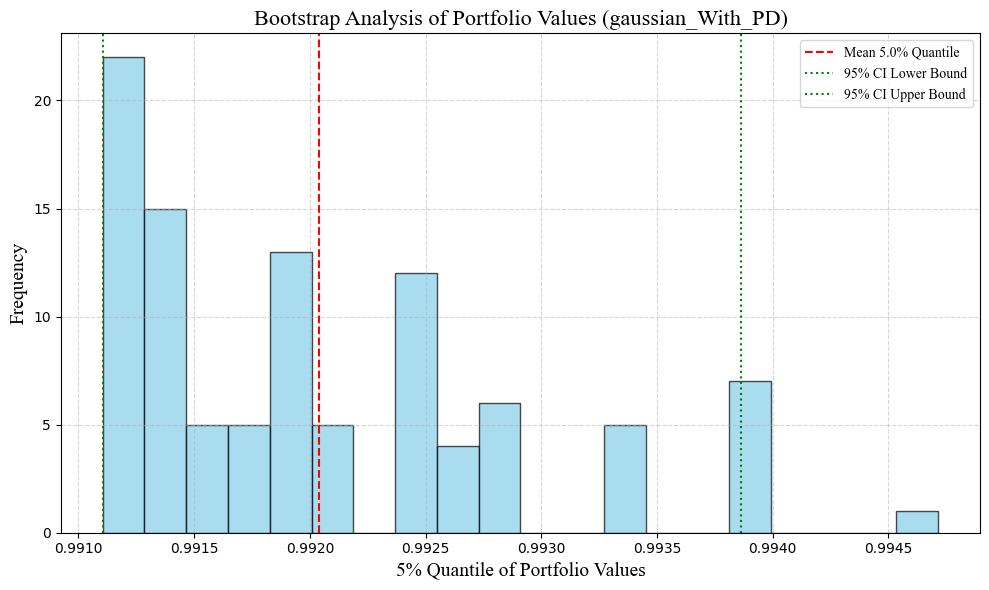

Bootstrap Results for gaussian_With_PD:
Mean 5% Quantile: 0.99204155
95% CI: [0.991105, 0.993865]


In [28]:
def perform_bootstrap_analysis(simulation_results, scenario_label, quantile=0.05, m=0.4, num_bootstraps=100, save_path="bootstrap_analysis.png"):
    """
    Performs bootstrap analysis on portfolio values and plots the stability.

    Parameters:
    - simulation_results (dict): Dictionary containing simulation results.
    - scenario_label (str): Specific scenario label for analysis.
    - quantile (float): Quantile to compute (e.g., 0.05 for 5%).
    - m (float): Subsampling ratio (e.g., 0.4 for 40%).
    - num_bootstraps (int): Number of bootstrap samples.
    - save_path (str): File path to save the bootstrap plot.

    Returns:
    - boot_mean (float): Mean of bootstrapped quantiles.
    - boot_lb (float): Lower bound of the bootstrapped quantile.
    - boot_up (float): Upper bound of the bootstrapped quantile.
    """
    if scenario_label not in simulation_results:
        print(f"Scenario '{scenario_label}' not found in simulation results.")
        return
    
    portfolio_values = simulation_results[scenario_label]["portfolio_values"].values
    
    bootstrapped_quantiles = []
    for _ in range(num_bootstraps):
        sample = np.random.choice(portfolio_values, size=int(len(portfolio_values)*m), replace=False)
        boot_q = np.quantile(sample, quantile)
        bootstrapped_quantiles.append(boot_q)
    
    boot_mean = np.mean(bootstrapped_quantiles)
    boot_lb = np.quantile(bootstrapped_quantiles, 0.025)  # 95% CI lower bound
    boot_up = np.quantile(bootstrapped_quantiles, 0.975)  # 95% CI upper bound
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(bootstrapped_quantiles, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(boot_mean, color='red', linestyle='--', label=f"Mean {quantile*100}% Quantile")
    plt.axvline(boot_lb, color='green', linestyle=':', label="95% CI Lower Bound")
    plt.axvline(boot_up, color='green', linestyle=':', label="95% CI Upper Bound")
    plt.xlabel(f"{int(quantile*100)}% Quantile of Portfolio Values", fontsize=14, fontfamily="Times New Roman")
    plt.ylabel("Frequency", fontsize=14, fontfamily="Times New Roman")
    plt.title(f"Bootstrap Analysis of Portfolio Values ({scenario_label})", fontsize=16, fontfamily="Times New Roman")
    plt.legend(fontsize=12, prop=font_manager.FontProperties(family="Times New Roman"))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(save_path, transparent=True)
    plt.show()
    plt.close()
    
    return boot_mean, boot_lb, boot_up

# Define the specific scenario for bootstrap analysis
bootstrap_scenario = 'gaussian_With_PD'  # Example: 't_With_PD', 'vine_With_PD', etc.

# Perform and plot bootstrap analysis
boot_mean, boot_lb, boot_up = perform_bootstrap_analysis(
    simulation_results=simulation_results,
    scenario_label=bootstrap_scenario,
    quantile=0.05,
    m=0.4,
    num_bootstraps=100,
    save_path=f"bootstrap_analysis_{bootstrap_scenario}.png"
)

print(f"Bootstrap Results for {bootstrap_scenario}:")
print(f"Mean 5% Quantile: {boot_mean}")
print(f"95% CI: [{boot_lb}, {boot_up}]")


______